# CCSN Neutrino Luminosity

Test initialization of neutrino source luminosity.

In [1]:
%matplotlib inline

from asteria import config, source
from asteria.neutrino import Flavor

import astropy.units as u

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

## Setup styles for Plotting

In [2]:
axes_style =   {            'grid' : 'True',
                       'labelsize' : '24',
                        'labelpad' : '8.0' }

xtick_style =  {       'direction' : 'out',
                       'labelsize' : '20.',
                      'major.size' : '5.',   
                     'major.width' : '1.',
                   'minor.visible' : 'True',
                      'minor.size' : '2.5',
                     'minor.width' : '1.' }

ytick_style =  {       'direction' : 'out',
                       'labelsize' : '20.',
                      'major.size' : '5',   
                     'major.width' : '1.',
                   'minor.visible' : 'True',
                      'minor.size' : '2.5',
                     'minor.width' : '1.' }

grid_style =   {           'alpha' : '0.75' }
legend_style = {        'fontsize' : '18' }
font_syle =    {            'size' : '20'}
text_style =   {          'usetex' : 'True' }
figure_style = {  'subplot.hspace' : '0.05' }

mpl.rc(    'font', **font_syle )
mpl.rc(    'text', **text_style )
mpl.rc(    'axes', **axes_style )
mpl.rc(   'xtick', **xtick_style )
mpl.rc(   'ytick', **ytick_style )
mpl.rc(    'grid', **grid_style )
mpl.rc(  'legend', **legend_style )
mpl.rc(  'figure', **figure_style )

mpl.rcParams['text.usetex'] = True 
mpl.rcParams['text.latex.preamble'] = [r'\usepackage[cm]{sfmath}']

## Load Configuration

This will load the source configuration from a file.

For this to work, either the user needs to have done one of two things:
1. Run `python setup.py install` in the ASTERIA directory.
2. Run `python setup.py develop` and set the environment variable `ASTERIA` to point to the git source checkout.

If these were not done, the initialization will fail because the paths will not be correctly resolved.

In [3]:
conf = config.load_config('../../data/config/test.yaml')
ccsn = source.initialize(conf)

## Simple Plotting Example
This will plot the luminosity for each neutrino flavor over from 0.5 seconds before the core bounce to 2.5 seconds after the core bounce.

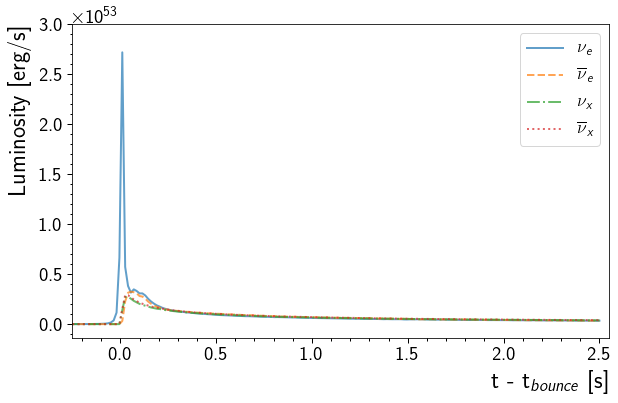

In [4]:
fig, ax = plt.subplots(1,1, figsize=(9,6))

t = np.linspace(-0.5, 2.5, 201) * u.s
for ls, flavor in zip(["-", "--", "-.", ":"], Flavor):
    lum = ccsn.get_luminosity(t, flavor)
    ax.plot(t, lum, ls, lw=2, label=flavor.to_tex(), alpha=0.7)

ax.set( xlim=(-0.255, 2.55), yticks=np.linspace(0, 3e53, 7) )
ax.set_xlabel('t - t$_{bounce}$ [s]', horizontalalignment='right', x=1.0)
ax.set_ylabel('Luminosity [erg/s]', horizontalalignment='right', y=1.0)
ax.legend()
ax.grid()
fig.tight_layout()

## Define Helper Functions

Define Functions for plotting, retrieving information from Data Files

- `drawComparison` plots USSR's reported values against ASTERIA's reported values and computes the difference and percent difference of ASTERIA's reported value relative to USSR's reported value. The average percent difference is denoted $\bar{\Delta}_\%$. This average was taken over the entire curve excluding any points where USSR returned a value of 0.

  - `drawComparison` assumes that the two quantities being compared are plotted on the same domain, which is the case in this notebook.
  

- `getUSSRdata` retrieves the specified file from `data\USSR\`. The array size is specified in the first line of the file's header. 
  - `getUSSRdata` assumes that the data is sorted into columns such that the first is time in seconds and the next four are USSR's reported values for each flavor in the order $\nu_e$, $\bar{\nu}_e$, $\nu_x$, $\bar{\nu}_x$. The files in `data\USSR\` were written according to this ordering.


In [5]:
def drawComparison(t, ussr_y, astr_y, flavor, label='', units=''): 
    # Compute difference and percent difference relative to USSR
    diff =  ussr_y - astr_y    
    pct_diff = 100*np.divide( abs(diff), ussr_y, 
                              where=ussr_y>0, 
                              out=np.zeros_like(ussr_y) )
    
    # Compute average percent difference excluding where USSR Reported 0
    avg_pct_diff = np.mean( pct_diff[pct_diff>0] )
    
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(9,6), 
                                   gridspec_kw = {'height_ratios':[5, 1]}, 
                                   sharex=True)
    
    # Plot USSR and ASTERIA against Each other.
    # Plot the difference between the two on the same figure.
    # Plot the percent difference on a subplot with a shared x-axis
    ax1.step( t, ussr_y, label='USSR')
    ax1.step( t, astr_y, label='ASTERIA')
    ax1.step( t, diff, 'k', label = 'Residual: USSR-ASTERIA', alpha=.50)     
    ax2.step( t, pct_diff, 'r', label = r'\% Diff. $\bar{\Delta}_\%$'+'={0:4.2f}\%'.format(avg_pct_diff))
    
    ax1.set_ylabel( label+' '+units, horizontalalignment='right', y = 1)
    ax2.set_xlabel("t -t$_{bounce}$ [s]", horizontalalignment='right', x = 1)
    ax2.set_yscale('log')
    
    # Group the labels of all lines in one legend object and display on axis 1
    handles, labels = ax1.get_legend_handles_labels()
    handles.append(ax2.get_legend_handles_labels()[0][0])
    labels.append(ax2.get_legend_handles_labels()[1][0])
    legend = ax1.legend( handles, labels )
    
    ax1.set_title( label+' Comparison: '+ flavor.to_tex() )
    # Return figure and axis handles for additional manipulation.
    return fig, (ax1, ax2)
    
def getUSSRdata(file):  
    with open('../../data/USSR/'+file ) as inFile:
        # Get Size of data from first line and initialize.
        line = inFile.readline().strip('#').replace(',','').split()
        t = np.zeros( int(line[1]) )
        data = np.zeros( shape=( int(line[0]), int(line[1])) )
        
        # Clear other lines of header
        inFile.readline() 
        inFile.readline() 
        i = 0
        for line in inFile:
            line = line.split()
            t[i] = float(line[0])
            for nu, item in enumerate(line[1:]):
                data[nu][i] = float(item)
            i+=1
    return t, data

## Plot Luminosity Comparisons for Each Flavor
This will compare each flavor's luminosity as it is reported by ASTERIA and USSR. The curve from 0.25 seconds before the core bounce to 1.75 seconds after the core bounce is shown.

__NOTE (03/13/19)__: For this model, the plots have different y-scales, as the Luminosity of $\nu_e$ is $\mathcal{O}(10)$ times greater than other flavors.



/home/sgris/Code/venvs/Asteria/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/sgris/Code/venvs/Asteria/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/sgris/Code/venvs/Asteria/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/sgris/Code/venvs/Asteria/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/sgris/Code/venvs/Asteria/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


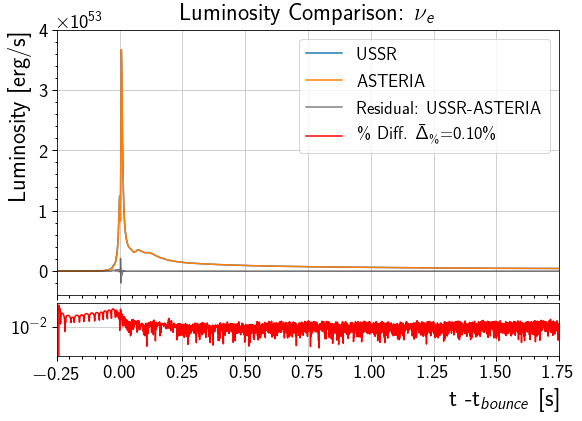

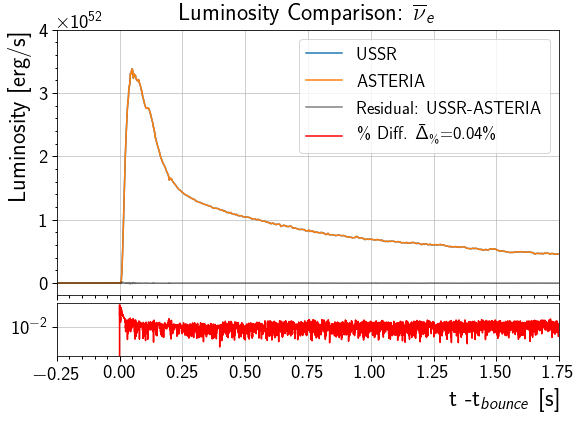

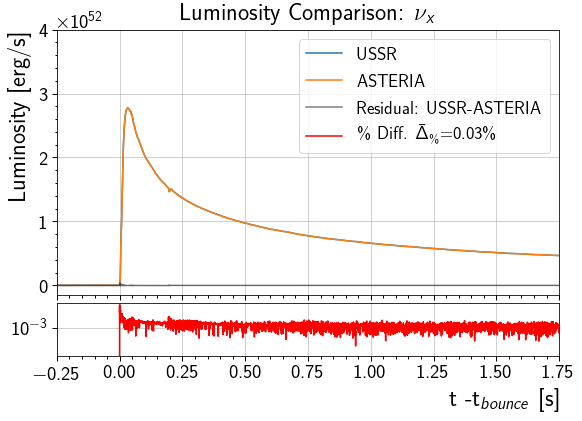

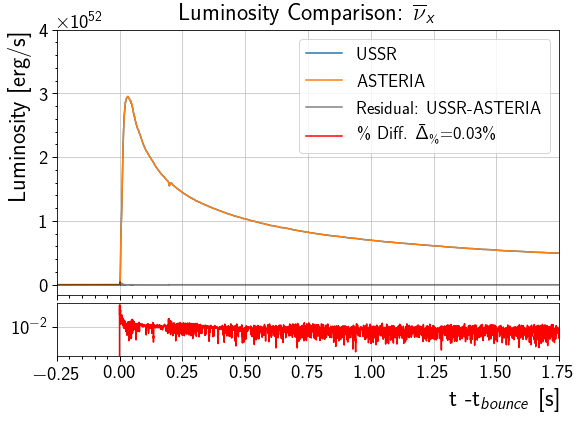

In [6]:
t, ussrLum = getUSSRdata('stellar_luminosity.txt')
for nu,flavor in enumerate(Flavor):
    astrLum = ccsn.get_luminosity( t, flavor ).to(u.erg/u.s).value
    fig, (ax1, ax2) = drawComparison(t ,ussrLum[nu], astrLum, flavor, 'Luminosity', '[erg/s]')

    if not nu: 
        ax1.set( xlim=(-0.25, 1.75),  
                 yticks=np.linspace(0, 4e53, 5) )
    else:
        ax1.set( xlim=(-0.25, 1.75), 
                 yticks=np.linspace(0, 4e52, 5) )


## Plot Mean Neutrino Energy Comparisons for Each Flavor
This will compare each flavor's mean energy as it is reported by ASTERIA and USSR. The curve from 0.25 seconds before the core bounce to 1.75 seconds after the core bounce is shown.

USSR Mean $\nu$ energy was estimated by inverting the flux calculation USSR performs. That is,

$$\langle E_{\nu}(t) \rangle = \frac{L(t) * \delta t}{ f(t) }$$

With Luminosity $ L(t)$, Flux $f(t)$, and signature time resolution (0.1 ms) $\delta t$. USSR only saves Flux and Luminosity, so this inversion was necessary to obtain mean energy from ROOT files when writing `stellar_mean_nu_energy.txt`.

__NOTE (03/13/19)__: ASTERIA uses cubic splines for interpolation, causing it to report $E_\nu < 0$ For a very small interval  $ t \in (-0.0158, -0.0006)$s for flavors other than $\nu_e$. At this point, those flavors' luminosity is very small ( $\mathcal{O}(10^{43})$ erg/s ) on this interval relative to the rest of the luminosity curve. For this reason, the effect of negative $E_\nu$ is supressed in flux and detector response.

/home/sgris/Code/venvs/Asteria/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/sgris/Code/venvs/Asteria/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/sgris/Code/venvs/Asteria/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


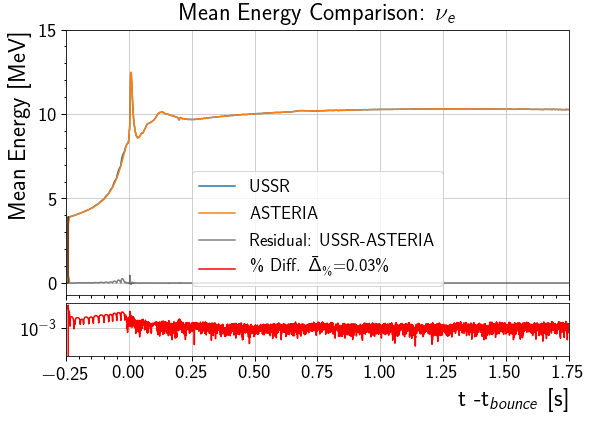

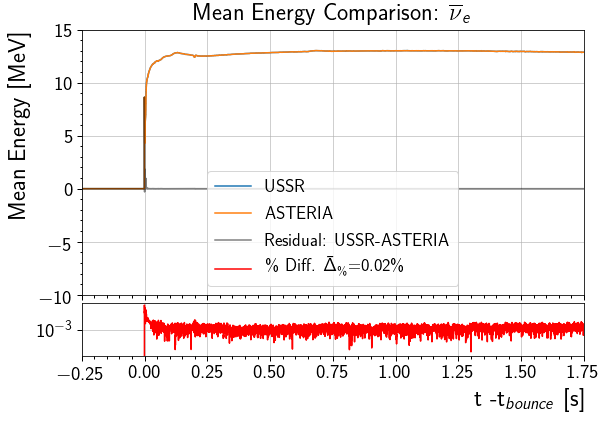

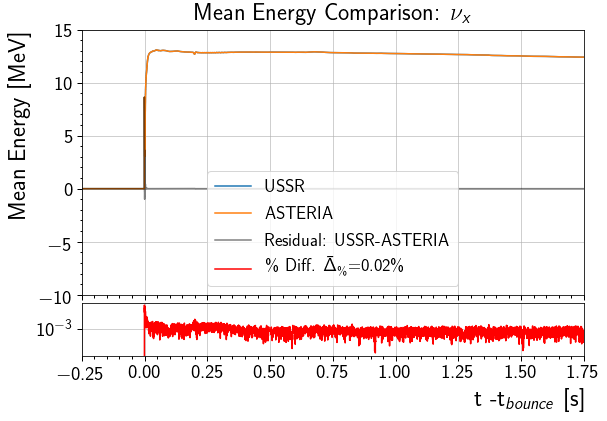

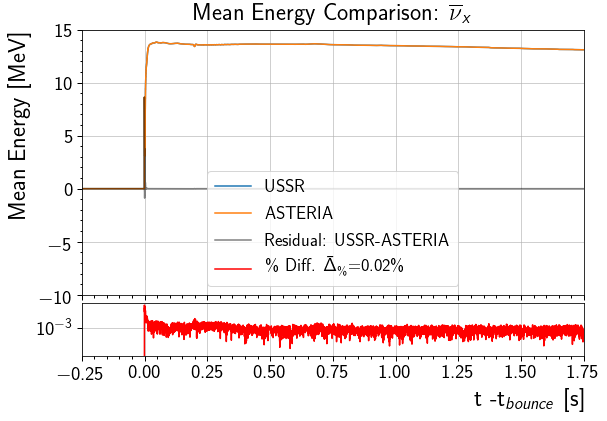

In [7]:
t, ussrmE = getUSSRdata('stellar_mean_nu_energy.txt')
for nu,flavor in enumerate(Flavor):
    astrmE = ccsn.get_mean_energy( t, flavor ).to(u.MeV).value
    fig, (ax1, ax2) = drawComparison(t,ussrmE[nu], astrmE, flavor, 'Mean Energy', '[MeV]')

    if not nu:
        ax1.set( xlim=(-0.25, 1.75),  
                 yticks=np.linspace(0, 15, 4) )
    else:
        ax1.set( xlim=(-0.25, 1.75),  
                 yticks=np.linspace(-10, 15, 6) )

## Plot Number Flux Comparisons for Each Flavor
This will compare each flavor's flux as it is reported by ASTERIA and USSR. The curve from 0.25 seconds before the core bounce to 1.75 seconds after the core bounce is shown.

Number flux was estimated by dividing the neutrino luminosity by its mean energy and numerically integrating over a $0.1$ms time bin. The result is the number of neutrinos emitted over a $0.1$ms at the source (1/4$\pi R^2$ losses are ignored here).

__NOTE (03/13/19)__: the plots have different y-scales, as the flux of $\nu_e$ is $\mathcal{O}(10)$ times greater than other flavors.

/home/sgris/Code/venvs/Asteria/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/sgris/Code/venvs/Asteria/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/sgris/Code/venvs/Asteria/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


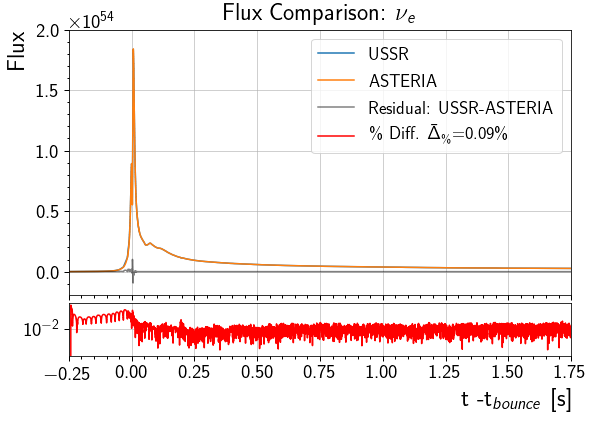

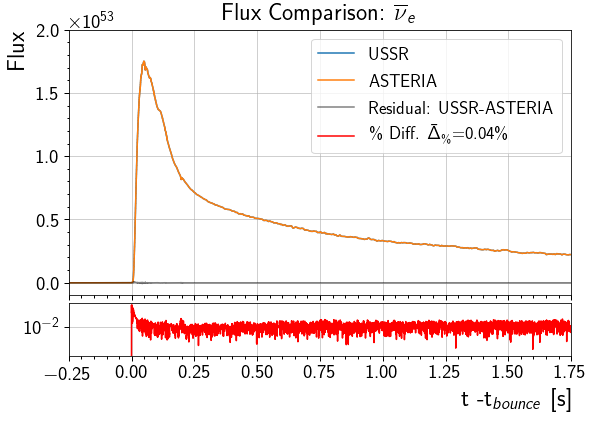

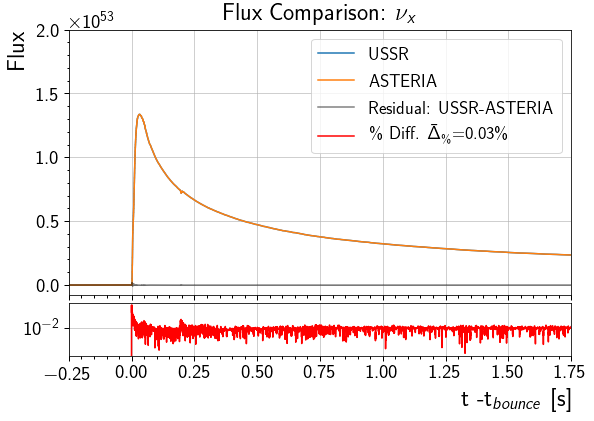

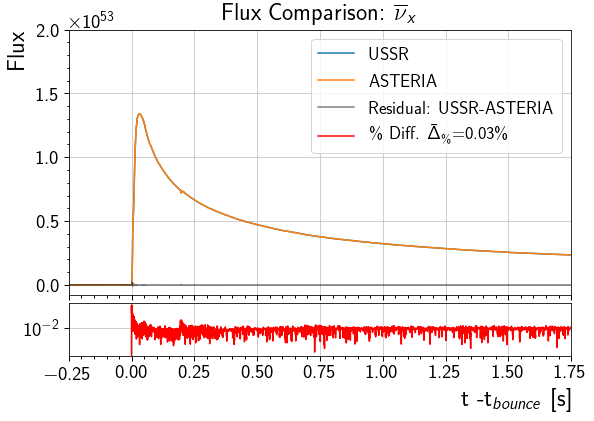

In [8]:
t, ussrFlux = getUSSRdata('stellar_flux.txt')
for nu,flavor in enumerate(Flavor):
    astrFlux = ccsn.get_flux( t*u.s, flavor )
    fig, (ax1, ax2)  = drawComparison(t,ussrFlux[nu], astrFlux, flavor, 'Flux')
    
    if not nu: 
        ax1.set( xlim=(-0.25, 1.75),  
                 yticks=np.linspace(0, 2e54, 5) )
    else:
        ax1.set( xlim=(-0.25, 1.75), 
                 yticks=np.linspace(0, 2e53, 5) )